In [14]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
import panel as pn
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact
from panel import widgets
from string import digits
from MCForecastTools import MCSimulation2

pn.extension()

%matplotlib inline

ModuleNotFoundError: No module named 'MCForecastTools'

In [2]:
# Read the ATLAS data into a Pandas DataFrame
atlas_file_path = Path("Resources/02_Deanonymized/ATLAS.csv")
forecast_data_file_path = Path("Resources/02_Deanonymized/2021 forecast CSV.csv")

atlas_raw = pd.read_csv(atlas_file_path, index_col="Customers")
forecast_data_raw = pd.read_csv(forecast_data_file_path, index_col="Organization Name")

atlas_raw.head()

,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service
Customers,,,,,,
University 1,3/20/2015,ATLAS 315,"$72,000.00",1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16
University 2,5/28/2015,AJ501,"$3,500.00",1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16
University 3,6/23/2015,AJ502,"$3,500.00",1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16
University 4,6/26/2015,AJ503,"$6,500.00",1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16
University 5,10/7/2015,AJ504,$750.00,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16


In [3]:
# Cleanup/preprocessing

## Cean up dates column (TODO functionalize)
dates_of_service = atlas_raw.iloc[0:6]["Dates of service "]

start_date_list = []
end_date_list = []

for date_of_service_str in dates_of_service:
    split1 = date_of_service_str.find("Subscription")
    split2 = split1 + len("Subscription")
    date_range = date_of_service_str[split2:].strip()

    split1 = date_range.find("to")
    split2 = split1 + len("to")
    date1_str = date_range[0:split1].strip()
    date2_str = date_range[split2:].strip()

    #print(f"date1_str: {date1_str}  date2_str: {date2_str}")
    date1 = pd.Timestamp(date1_str, tz="America/New_York").isoformat()
    date2 = pd.Timestamp(date2_str, tz="America/New_York").isoformat()
    #print(f"date1_str: {date1_str}  date1: {date1}")
    #print(f"date2_str: {date2_str}  date2: {date2}")

    start_date_list.append(date1)
    end_date_list.append(date2)

dates_df = pd.DataFrame({"Start date":start_date_list,"End date": end_date_list})
dates_df.head()
ATLAS_with_fixed_dates = pd.concat([atlas_raw.reset_index(), dates_df], axis='columns', join="inner")
ATLAS_with_fixed_dates.head()

,Customers,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service,Start date,End date
0,University 1,3/20/2015,ATLAS 315,"$72,000.00",1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16,2015-03-18T00:00:00-04:00,2016-06-30T00:00:00-04:00
1,University 2,5/28/2015,AJ501,"$3,500.00",1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
2,University 3,6/23/2015,AJ502,"$3,500.00",1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16,2015-06-10T00:00:00-04:00,2016-06-30T00:00:00-04:00
3,University 4,6/26/2015,AJ503,"$6,500.00",1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
4,University 5,10/7/2015,AJ504,$750.00,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16,2015-10-05T00:00:00-04:00,2016-09-30T00:00:00-04:00


In [4]:
# Removing ($) Sign from the Invoice Amount
ATLAS_with_fixed_dates["Invoice Amount"] = ATLAS_with_fixed_dates["Invoice Amount"].str.replace('$','')
ATLAS_with_fixed_dates["Invoice Amount"] = ATLAS_with_fixed_dates["Invoice Amount"].str.replace(',', '').astype('float')
print(ATLAS_with_fixed_dates.dtypes)
ATLAS_with_fixed_dates.head()

Customers             object
Invoice Date          object
Invoice #             object
Invoice Amount       float64
Subscription          object
Account Code          object
Dates of service      object
Start date            object
End date              object
dtype: object


,Customers,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service,Start date,End date
0,University 1,3/20/2015,ATLAS 315,72000.0,1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16,2015-03-18T00:00:00-04:00,2016-06-30T00:00:00-04:00
1,University 2,5/28/2015,AJ501,3500.0,1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
2,University 3,6/23/2015,AJ502,3500.0,1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16,2015-06-10T00:00:00-04:00,2016-06-30T00:00:00-04:00
3,University 4,6/26/2015,AJ503,6500.0,1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
4,University 5,10/7/2015,AJ504,750.0,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16,2015-10-05T00:00:00-04:00,2016-09-30T00:00:00-04:00


<AxesSubplot:title={'center':'Invoice Amount over Time'}, xlabel='Start date'>

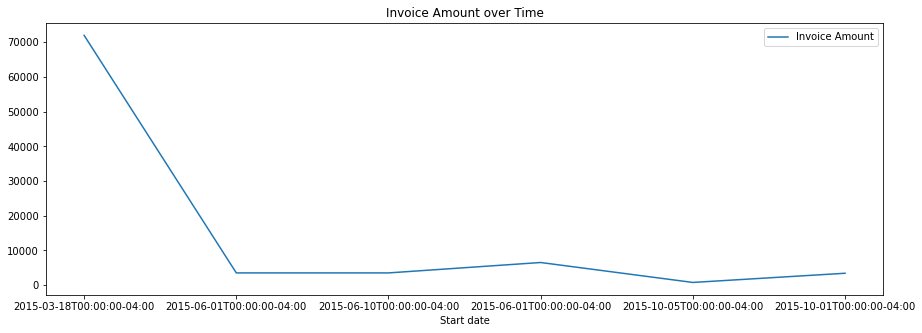

In [5]:
ATLAS_with_fixed_dates.plot.line(x="Start date", y="Invoice Amount", figsize=(15, 5), title="Invoice Amount over Time")

In [6]:
ATLAS_with_fixed_dates.head()

,Customers,Invoice Date,Invoice #,Invoice Amount,Subscription,Account Code,Dates of service,Start date,End date
0,University 1,3/20/2015,ATLAS 315,72000.0,1 Year,4700-0-00-00000-18-0000,1 Year Subscription 3/18/15 to 6/30/16,2015-03-18T00:00:00-04:00,2016-06-30T00:00:00-04:00
1,University 2,5/28/2015,AJ501,3500.0,1 Year,4700-0-00-00000-16-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
2,University 3,6/23/2015,AJ502,3500.0,1 Year,4700-0-00-00000-17-0000,1 Year Subscription 6/10/15 to 6/30/16,2015-06-10T00:00:00-04:00,2016-06-30T00:00:00-04:00
3,University 4,6/26/2015,AJ503,6500.0,1 Year,4700-0-00-00000-32-0000,1 Year Subscription 6/1/15 to 6/30/16,2015-06-01T00:00:00-04:00,2016-06-30T00:00:00-04:00
4,University 5,10/7/2015,AJ504,750.0,1 Year,4700-0-00-00000-20-0000,1 Year Subscription 10/05/15 to 9/30/16,2015-10-05T00:00:00-04:00,2016-09-30T00:00:00-04:00


In [7]:
ATLAS_with_fixed_dates["Start date"]

0    2015-03-18T00:00:00-04:00
1    2015-06-01T00:00:00-04:00
2    2015-06-10T00:00:00-04:00
3    2015-06-01T00:00:00-04:00
4    2015-10-05T00:00:00-04:00
5    2015-10-01T00:00:00-04:00
Name: Start date, dtype: object

In [8]:
ATLAS_with_fixed_dates["Invoice Amount"].values

array([72000.,  3500.,  3500.,  6500.,   750.,  3400.])

In [11]:

# dates_df = pd.DataFrame({"Start date":start_date_list,"End date": end_date_list})



# mc_data = pd.concat(
#     { "TSLA": [
#         ATLAS_with_fixed_dates["Start date"].values,
#         ATLAS_with_fixed_dates["Invoice Amount"],
#         ATLAS_with_fixed_dates["Invoice Amount"].diff().values
#     ]
#     },
#     axis='columns', join="inner")

mc_data = pd.concat(
    [ATLAS_with_fixed_dates["Start date"], ATLAS_with_fixed_dates["Invoice Amount"], ATLAS_with_fixed_dates["Invoice Amount"].diff()],
    axis='columns', join="inner")

mc_data.dropna(inplace=True)
mc_data.set_index("Start date", inplace=True)
mc_data.columns=['close', 'daily_return']
mc_data.head()

portfolio_weights = [.4, .6]
mc = MCSimulation2(
    portfolio_data = mc_data,
    weights = [1.0],
    num_simulation = 10,
    num_trading_days = 10
)

# mc.calc_cumulative_return()



# mc_data.columns.get_level_values(1).unique()


ModuleNotFoundError: No module named 'MCForecastTools'